In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
repo_url = "https://github.com/aakashvardhan/s22-unet-vae.git"

local_dir = '/content/s22-unet-vae'



# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

Cloning into 's22-unet-vae'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 151 (delta 70), reused 128 (delta 47), pack-reused 0
Receiving objects: 100% (151/151), 112.40 KiB | 650.00 KiB/s, done.
Resolving deltas: 100% (70/70), done.


In [4]:
%cd s22-unet-vae

/content/s22-unet-vae


In [5]:
import sys

sys.path.append('.')
sys.path.append('./models')
sys.path.append('./data')
sys.path.append('./notebooks')
sys.path.append('./utils')

In [6]:
!pip install -q -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 13.2 MB/s eta 0:00:00


In [7]:
from lightning.pytorch import Trainer, seed_everything
import lightning as pl
from lightning.pytorch.callbacks import (ModelCheckpoint,
                                         LearningRateMonitor,
                                         RichModelSummary,
                                         EarlyStopping)
from config import UNetConfig, load_config, update_config
import torch
import os
from lit_unet import LitUNet
from datamodule import DataModule
from callbacks import ClassAccuracyLoss, PlotExampleCallback
import wandb
from lightning.pytorch.loggers import WandbLogger

os.environ["WANDB_NOTEBOOK_NAME"] = "./notebooks/train-unet-model-1.ipynb"
wandb.init(settings=wandb.Settings(_service_wait=300))

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
torch.cuda.empty_cache()
pl.seed_everything(42, workers=True)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

In [9]:
config = UNetConfig()
json_data = load_config("training_1.json")
config = update_config(config, json_data)
print(config)

UNetConfig(in_channels=3, out_channels=3, num_filters=64, num_layers=4, batch_size=16, learning_rate=0.001, epochs=25, root_dir='./data', height=240, width=240, optimizer='adam', loss_function='cross_entropy', channel_reduction_method='max_pool', channel_expansion_method='conv_transpose', softmax_dim=1, dropout_rate=0.5, augmentation=True)


In [10]:
config.batch_size = 32
print(config)

UNetConfig(in_channels=3, out_channels=3, num_filters=64, num_layers=4, batch_size=32, learning_rate=0.001, epochs=25, root_dir='./data', height=240, width=240, optimizer='adam', loss_function='cross_entropy', channel_reduction_method='max_pool', channel_expansion_method='conv_transpose', softmax_dim=1, dropout_rate=0.5, augmentation=True)


In [11]:
# initialise the wandb logger and name your wandb project
wandb_logger = WandbLogger(project='s22-unet')

# add your batch size to the wandb config
wandb_logger.experiment.config["batch_size"] = config.batch_size

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [12]:
data_module = DataModule(config)
data_module.setup()

100%|██████████| 791918971/791918971 [00:31<00:00, 24969122.32it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10800356.78it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [13]:
model = LitUNet(config)

In [14]:
callback = [ModelCheckpoint(dirpath="checkpoints/",
                                                         save_top_k=3,
                                                         monitor="val_loss",
                                                         mode="min",
                                                         filename="model-{epoch:02d}-{val_loss:.2f}-{val_loss:4f}",
                                                         save_last=True,
                                                         verbose=True,),
                              ClassAccuracyLoss(),
                              PlotExampleCallback()
                              LearningRateMonitor(logging_interval='step', log_momentum=True)]

In [15]:
trainer = pl.Trainer(precision="16-mixed",
                     max_epochs= config.epochs,
                     accelerator="cuda",
                     devices="auto",
                     logger = wandb_logger,
                     callbacks=callback,
                    check_val_every_n_epoch=3,
                    num_sanity_val_steps=2)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Finding best initial lr:   0%|          | 0/25 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=25` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=25` reached.
INFO: Learning rate set to 0.036307805477010145
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.036307805477010145
INFO: Restoring states from the checkpoint path at /content/s22-unet-vae/.lr_find_4d44ae68-6454-4ed0-a334-2a89ea5b8f58.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/s22-unet-vae/.lr_find_4d44ae68-6454-4ed0-a334-2a89ea5b8f58.ckpt
INFO: Restored all states from the checkpoint at /content/s22-unet-vae/.lr_find_4d44ae68-6454-4ed0-a334-2a89ea5b8f58.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/s22-unet-vae/.lr_find_4d44ae68-6454-4ed0-a334-2a89ea5b8f58.ckpt


new_lr=0.036307805477010145


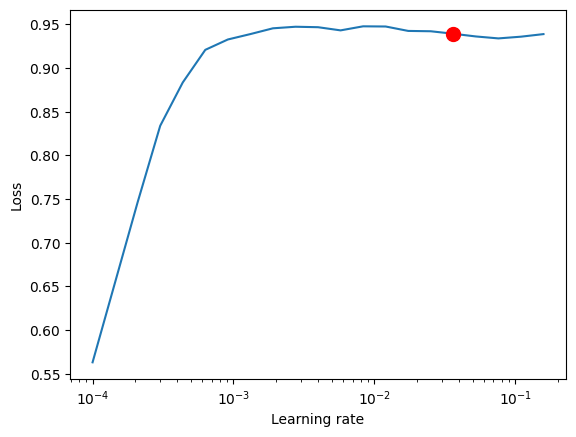

In [16]:
from lightning.pytorch.tuner import Tuner

# Create a Tuner
tuner = Tuner(trainer)

# Finding the learning rate
lr_finder =tuner.lr_find(model,datamodule=data_module, min_lr=1e-4, max_lr=1, num_training=trainer.max_epochs,attr_name='learning_rate')

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")

In [17]:
model.best_lr = new_lr

In [18]:
model.learning_rate = config.learning_rate

In [19]:
trainer.fit(model=model, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | UNet               | 8.6 M  | train
1 | train_acc     | MulticlassAccuracy | 0      | train
2 | valid_acc     | MulticlassAccuracy | 0      | train
3 | loss_function | CrossEntropyLoss   | 0      | train
-------------------------------------------------------------
8.6 M     Trainable params
0         Non-trainable params
8.6 M     Total params
34.253    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | UNet               | 8.6 M  | train
1 | train_acc     | MulticlassAccuracy | 0      | train
2 | valid_acc     | MulticlassAccuracy | 0      | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


 Epoch: 0 | Val Loss: 1.10192 | Val Acc: 0.29904


Training: |          | 0/? [00:00<?, ?it/s]


 Epoch: 0 | Train Loss: 0.82167 | Train Acc: 0.62326

 Epoch: 1 | Train Loss: 0.71106 | Train Acc: 0.70322


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 276: 'val_loss' reached 1.31520 (best 1.31520), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=02-val_loss=1.32-val_loss=1.315201.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 276: 'val_loss' reached 1.31520 (best 1.31520), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=02-val_loss=1.32-val_loss=1.315201.ckpt' as top 3



 Epoch: 2 | Val Loss: 1.31520 | Val Acc: 0.59443

 Epoch: 2 | Train Loss: 0.69020 | Train Acc: 0.71832

 Epoch: 3 | Train Loss: 0.65872 | Train Acc: 0.73312

 Epoch: 4 | Train Loss: 0.63158 | Train Acc: 0.74589


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 552: 'val_loss' reached 1.60181 (best 1.31520), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=05-val_loss=1.60-val_loss=1.601810.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 552: 'val_loss' reached 1.60181 (best 1.31520), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=05-val_loss=1.60-val_loss=1.601810.ckpt' as top 3



 Epoch: 5 | Val Loss: 1.60181 | Val Acc: 0.59818

 Epoch: 5 | Train Loss: 0.58946 | Train Acc: 0.76528

 Epoch: 6 | Train Loss: 0.55230 | Train Acc: 0.78257

 Epoch: 7 | Train Loss: 0.51374 | Train Acc: 0.79975


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 828: 'val_loss' reached 1.72654 (best 1.31520), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=08-val_loss=1.73-val_loss=1.726541.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 828: 'val_loss' reached 1.72654 (best 1.31520), saving model to '/content/s22-unet-vae/checkpoints/model-epoch=08-val_loss=1.73-val_loss=1.726541.ckpt' as top 3



 Epoch: 8 | Val Loss: 1.72654 | Val Acc: 0.59576

 Epoch: 8 | Train Loss: 0.48311 | Train Acc: 0.81304


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
